In [1]:
from os import environ as ENV
import sys
sys.path.append(ENV['PWD'])

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import Akima1DInterpolator

from should_be_stdlib import resample_log

In [3]:
from neurodata import *
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons].reset_index().drop(columns='index')
coords = get_coords(record).loc[sig_neurons]

In [4]:
# ½ octave with equal temperament (reasonable guess)
old_freqs = resample_log([3,48], 9)
new_freqs = resample_log([3,48], 16)
old_freqs, new_freqs

(array([ 3.        ,  4.24264069,  6.        ,  8.48528137, 12.        ,
        16.97056275, 24.        , 33.9411255 , 48.        ]),
 array([ 3.        ,  3.60907511,  4.34180771,  5.22330338,  6.28376474,
         7.5595263 ,  9.0942994 , 10.94066986, 13.16189976, 15.83409493,
        19.04881262, 22.91619849, 27.56876052, 33.16590912, 39.89941901,
        48.        ]))

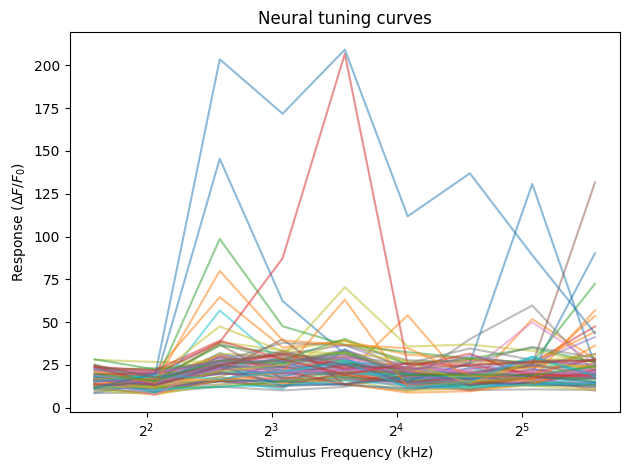

In [24]:
tuning_curves.columns = old_freqs.round(1)
tuning_curves.set_index(sig_neurons, inplace=True)
plt.plot(tuning_curves.T, alpha=0.5)
plt.title('Neural tuning curves')
plt.xlabel('Stimulus Frequency (kHz)')
plt.ylabel('Response ($ΔF/F_0$)')
plt.xscale('log', base=2)
plt.tight_layout()

plt.savefig(ENV['PWD'] + '/figures/tuning-curves.png', dpi=300)
plt.show()

In [17]:
# rescale tuning curves
def normalize(x, c=1):
    '''Normalize vector and rescale to c'''
    # Multiply then divide for numerical stability
    return x * c / np.linalg.norm(x, ord=1)

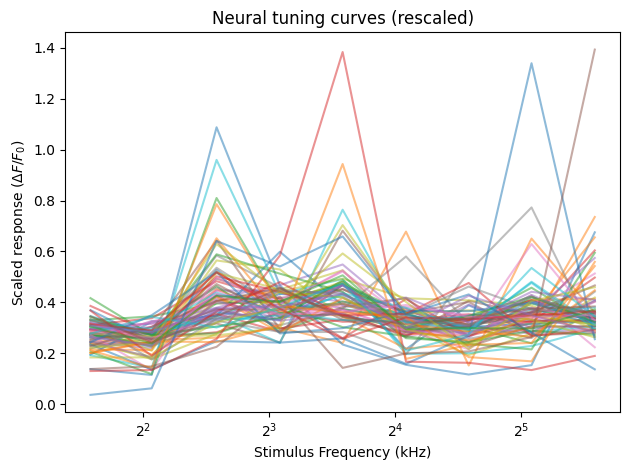

In [25]:
# tuning curves can't be negative. scale to pi so values range from [0, pi]
rescaled_tuning_curves = tuning_curves.apply(lambda x: normalize(x, c=np.pi), axis=1)
rescaled_tuning_curves.to_csv(ENV['PWD'] + '/data/rescaled_tuning_curves.csv')
plt.plot(rescaled_tuning_curves.T, alpha=0.5)
plt.title('Neural tuning curves (rescaled)')
plt.xlabel('Stimulus Frequency (kHz)')
plt.ylabel('Scaled response ($ΔF/F_0$)')
plt.xscale('log', base=2)

plt.tight_layout()

plt.savefig(ENV['PWD'] + '/figures/tuning-curves-rescaled.png', dpi=300)
plt.show()


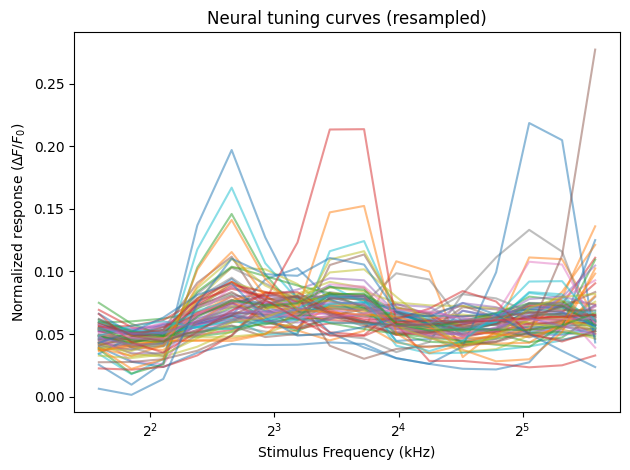

In [26]:
# upsample the tuning curves to fill the binary space
tuning_curves_upscaled = tuning_curves.apply(
    lambda response: Akima1DInterpolator(old_freqs, response, method="makima")(new_freqs),
    axis = 1,
    result_type = 'expand',
)
tuning_curves_upscaled.columns = new_freqs.round(1)

# tuning_curves_upscaled.to_csv(ENV['PWD'] + '/data/tuning_curves_upscaled.csv')
plt.plot(tuning_curves_upscaled.T.apply(lambda x: normalize(x)), alpha=0.5)
plt.title('Neural tuning curves (resampled)')
plt.xlabel('Stimulus Frequency (kHz)')
plt.ylabel('Normalized response ($ΔF/F_0$)')
plt.xscale('log', base=2)

plt.tight_layout()

plt.savefig(ENV['PWD'] + '/figures/tuning-curves-rescaled.png', dpi=300)
plt.show()
